In [60]:
from pyrosm import OSM
from pyrosm import get_data
import pandas as pd
import h3.api.numpy_int as h3 
import shapely
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

In [107]:
def flatten(lst):
    return [item for sublist in lst for item in (flatten(sublist) if isinstance(sublist, list) else [sublist])]

def h3_list_to_multi_poly(h3_list):
    h3_polygon = h3.h3_set_to_multi_polygon(h3_list)
    # for some reason you can't go straight to multiploly ////:
    return MultiPolygon([Polygon(p[0]) for p in h3_polygon])

def LineString_to_hex(line, H3_RES):
    l_coords = [x for x in line.coords]
    start = h3.geo_to_h3(l_coords[0][0], l_coords[0][1], H3_RES)
    end = h3.geo_to_h3(l_coords[-1][0], l_coords[-1][1], H3_RES)
    return h3.h3_line(start,end)

def all_shapley_geo_to_h3(obj, H3_RES):
    geom_type = obj.geom_type
    # assert geom_type valid at some point

    if geom_type=='MultiPolygon':
        # this will break in a different version of shapley, use this instead of iterating polys in multipoly: 
        # multi_poly.coords or .geoms
        return [ind for p in obj.geoms for ind in h3.polyfill(shapely.geometry.mapping(p), H3_RES)] # loop through polys and flatten
    elif geom_type=='Polygon':
        return h3.polyfill(shapely.geometry.mapping(obj), H3_RES)
    elif geom_type=='MultiLineString':
        # this will break in a different version of shapley, use this instead of iterating lines in multi_line: 
        # obj.coords or obj.geoms
        return [ind for l in obj.geoms for ind in LineString_to_hex(l,H3_RES)]
    elif geom_type=='LineString':
        return LineString_to_hex(obj, H3_RES)
    elif geom_type=='Point':
        return h3.geo_to_h3(obj.y, obj.x, H3_RES)
    else:
        print(f"unimplemented geom type: {geom_type}")
    

def plot_h3_and_geo(h3_index_list, shapely_geo):
    p = gpd.GeoSeries(shapely_geo)
    p2 = gpd.GeoSeries(h3_list_to_multi_poly(h3_index_list))
    gdf1 = gpd.GeoDataFrame(geometry=p)
    gdf2 = gpd.GeoDataFrame(geometry=p2)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the GeoDataFrames on the axis
    gdf1.plot(ax=ax, color='blue', alpha=0.5)
    gdf2.plot(ax=ax, color='red', alpha=0.5)

    plt.show()

In [2]:
H3_RES = 12
h3_tags = dict()

def coord_to_h3(lat, lon, category):
    h3_index = h3.geo_to_h3(lat, lon, H3_RES)
    try:
        h3_tags[h3_index].append(category)
    except:
        h3_tags[h3_index]=[category]

    return h3_index

In [3]:
osm = OSM("copenhagen_test.pbf")

In [242]:
# idea: EVERYONE can use it and live a healthy life with this as their only source
#check: doctors, clinic, health_food, food
#essential filter will be the least restrictive!

essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

essential_filter = {
    "amenity":True
    }

# n minute city must satisfy the following expression based on
# the existence of certain tags within n minutes:
category_set = set(['pharmacy','park','supermarket','sport','doctor','dentist'])

'''
n_minute_requirements = \
    # category_name = (boolean with all relevant osm tags)
    supermarket = (supermarket or greengrocer or wholesale or grocery) and \
    pharmacy = (pharmacy or medical_supply) and\
    park = (park) and\
    dentist = (dentist) and \
    doctor = (clinic or doctor or doctors) and \
    sport = any(sport)
'''
# easy use case which is debateably also essential
education_filter = {"amenity":["school"]}

In [243]:
pois = osm.get_pois(custom_filter=essential_filter)

/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [234]:
# some tags don't have headers, find manually in tags
def tag_conditions(tags, healthcare_list):
    # search for healthcare tag substring, return match
    s = [s for s in healthcare_list if s in tags]
    if s:
        return s[0]
    elif "sport" in tags:
        return "sport" 
    else:
        return None

osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

def osm_to_manual_category(tag):
    # faster than searching keys to try, except
    try:
        return osm_tag_mapping[tag]
    except:
        return tag


pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])
pois["poi_type"] = pois["poi_type"].fillna(pois["leisure"])

# some tags don't have a poi_type
pois['tags'] = pois['tags'].astype(str)
pois['no_header'] = pois.apply(lambda x: tag_conditions(x.tags, essential_filter['healthcare']), axis=1)
pois["poi_type"] = pois["poi_type"].fillna(pois["no_header"])

# convert to n minute city category
pois['category'] = pois["poi_type"].apply(osm_to_manual_category)

# convert all geometry to h3
h3_df = pois[['category','poi_type','geometry']].copy()
h3_df['h3_index'] = pois.apply(lambda x: all_shapley_geo_to_h3(x.geometry, H3_RES), axis=1)
h3_df = h3_df.explode('h3_index')
h3_df = h3_df[h3_df['category'].isin(category_set)]

KeyError: 'amenity'

In [214]:
h3_df['category'].value_counts()

park           164843
supermarket      1174
sport             808
doctor            181
pharmacy           80
dentist            28
Name: category, dtype: int64

In [8]:
pois["geom_type"] = pois.apply(lambda x: x.geometry.geom_type, axis=1)
pois['geom_type'].unique()

array(['Point', 'Polygon', 'MultiLineString', 'LineString',
       'MultiPolygon'], dtype=object)

In [108]:
# tests
polygon = pois[pois['geom_type']=='Polygon']['geometry'].values[0]
multi_poly = pois[pois['geom_type']=='MultiPolygon']['geometry'].values[0]
point = pois[pois['geom_type']=='Point']['geometry'].values[0]
line = pois[pois['geom_type']=='LineString']['geometry'].values[0]
multi_line = pois[pois['geom_type']=='MultiLineString']['geometry'].values[0]

test_poly = all_shapley_geo_to_h3(polygon, H3_RES)
test_multi_poly = all_shapley_geo_to_h3(multi_poly, H3_RES)
test_point = all_shapley_geo_to_h3(point, H3_RES)
test_line = all_shapley_geo_to_h3(line, H3_RES)
# these are all parks
# in order to test this yo uneed to plot a scatterplot of all hex cell centers bc converting to polygon fills in the holes
test_multi_line = all_shapley_geo_to_h3(multi_line, H3_RES)

In [ ]:
# misc filters
'''
check: marketplace, childcare, studio, food

work_filter = {"amenity":["coworking_space"]}

elderly_care = {"amenity":["nursing_home","retirement_home"]}

healthcare_filter = {"amenity": ["hospital","dentist","doctors","pharmacy","clinic"]}

sport_filter = {"amenity": ["climbing_wall","dojo"]}

culture_filter = {"amenity":["cinema","theatre","events_venue","arts_centre","place_of_worship","library","music_venue","community_centre","dancing_school","social_facility","gallery","social_centre","conference_centre","public_bath"]}

social_filter = {"amenity":["pub","bar","nightclub","cafe","internet_cafe"]}

food_filter = {"amenity":["restaurant","kitchen","food_court"],"shop":["supermarket","greengrocer","confectionery"]}

education_filter = {"amenity":["school","kindergarten","language_school"]}

'''

In [80]:
# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
# https://wiki.openstreetmap.org/wiki/Map_features
# there is overlap, basically no need to use building tag
custom_filter = {"amenity": True, "shop": True, "healthcare": True, "leisure": True, "sport": True, "building": True}
custom_filter = {"amenity": ["doctors"]}
#custom_filter = {"amenity":["clinic"]}

#pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
#pois["poi_type"] = pois["amenity"]
#pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [18]:
#pd.DataFrame(pois['poi_type'].value_counts()).to_csv("list_of_poi_types.csv")

In [199]:
h3_df

park           164843
supermarket      1174
sport             808
doctor            181
pharmacy           80
dentist            28
Name: category, dtype: int64

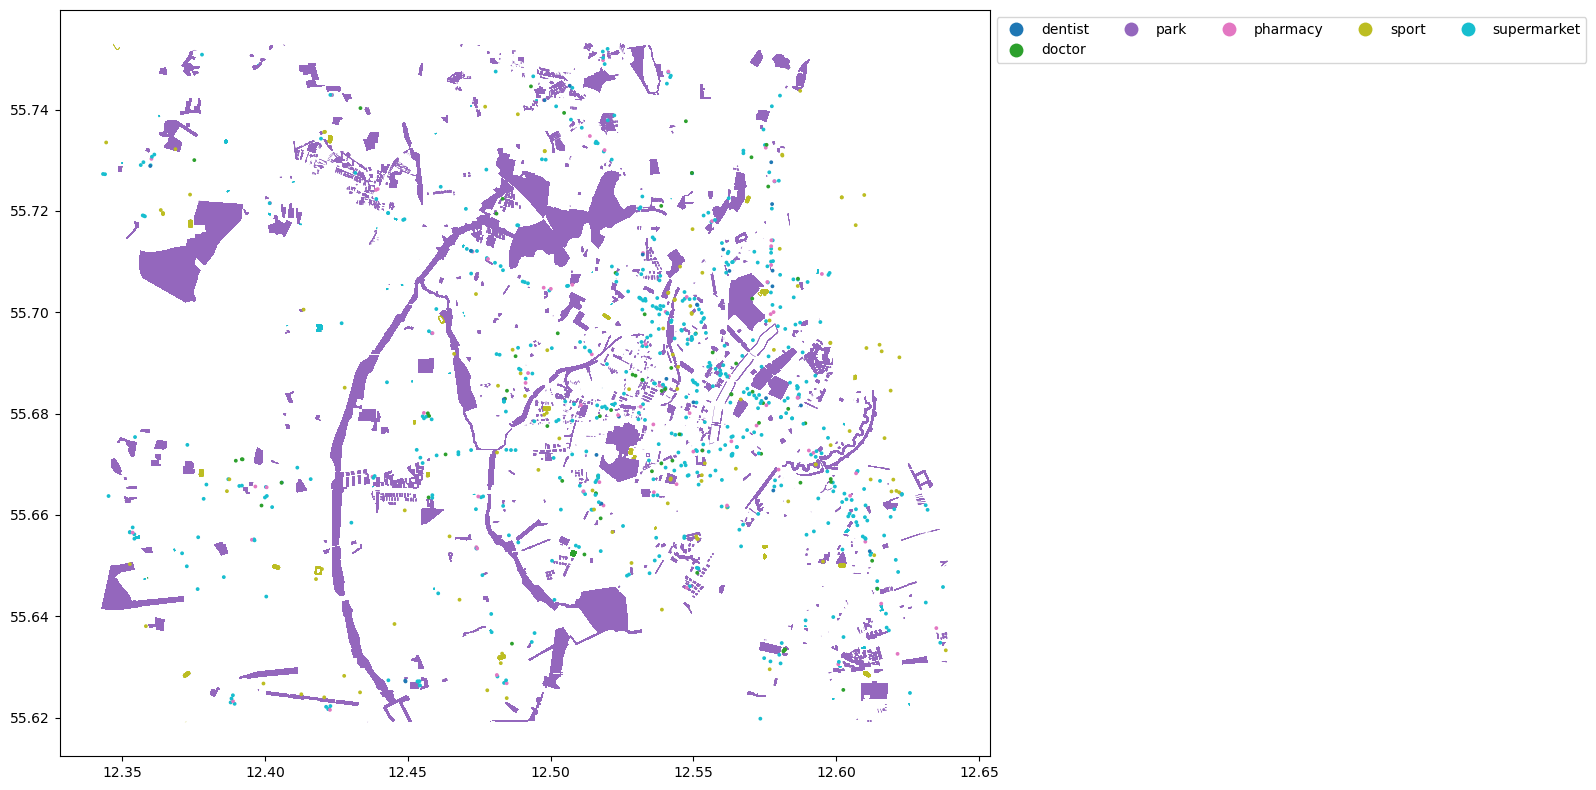

In [207]:
ax = h3_df.plot(column='category', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

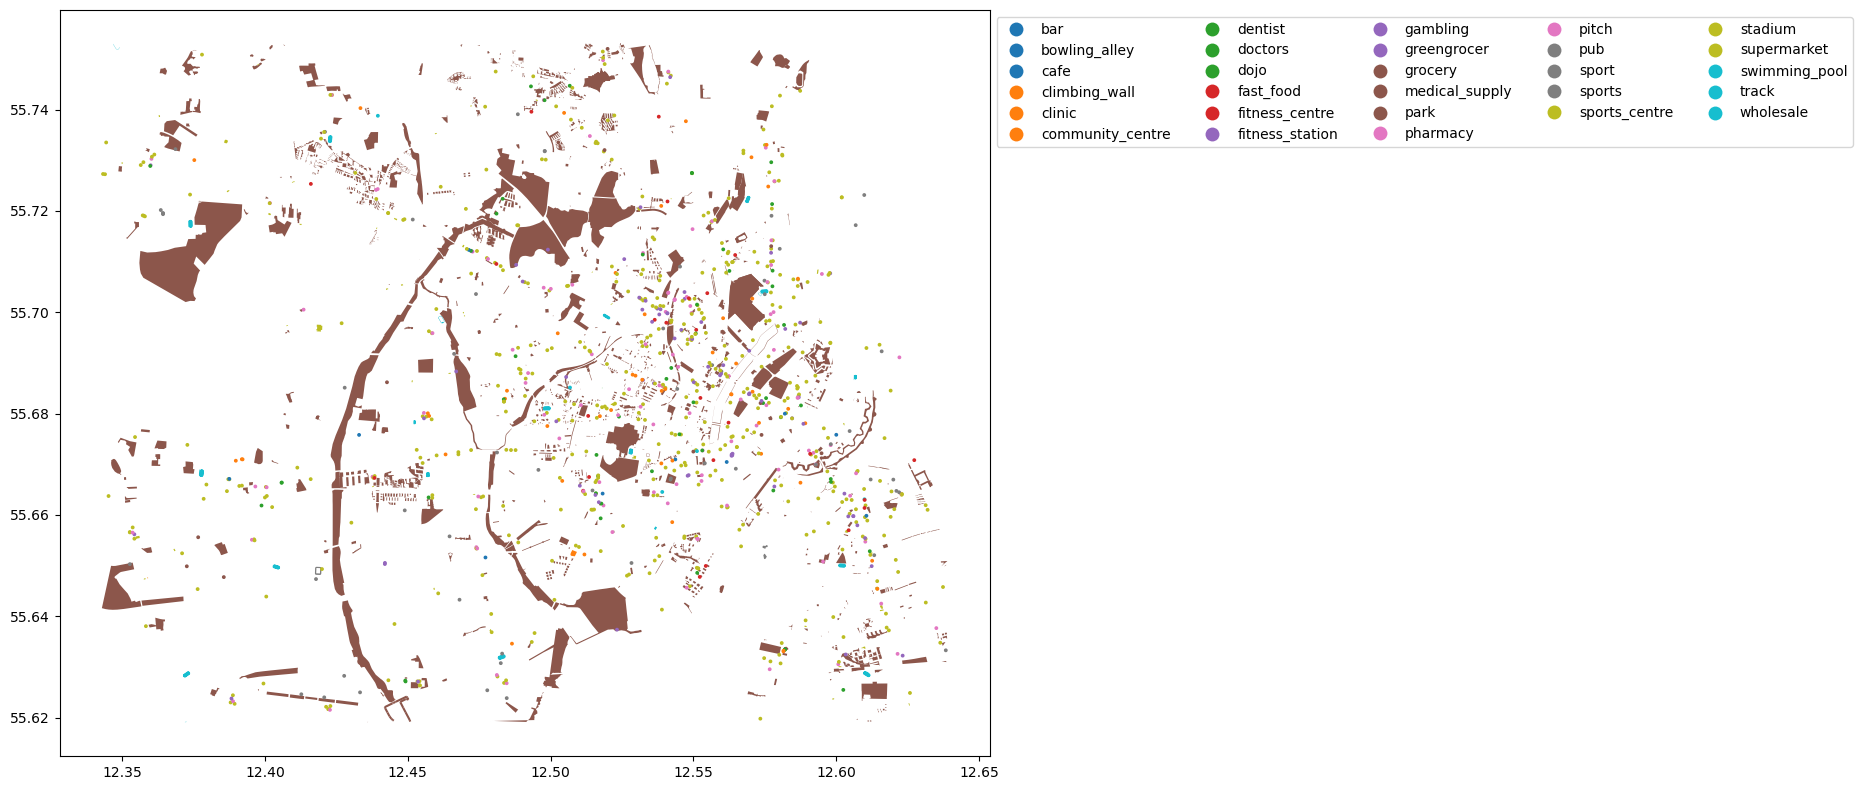

In [193]:
# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))